# Differential gene expression analysis per cell-type between conditions

In [63]:
#Load libraries
import pandas as pd
import numpy as np
import os
import subprocess as sp
import decoupler as dc
import scanpy as sc
import glob

# Libraries for visualization
from typing import Mapping, Optional, Sequence
import warnings
import scipy.stats
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import altair as alt
from itertools import zip_longest
import statsmodels.stats.multitest


# set PATH env variable to conda env for specific R version.
# To use [DESeq2, R version "4.2" required](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)
path_to_R = "/usr/local/bioinf/R/R-4.2.3/bin/"
os.environ["PATH"] = path_to_R + os.pathsep + os.environ["PATH"]

cpus = 6

# Configure paths
    - adata_path: Path to anndata file
    - deseq: Path to deseq2 script 
    - deseq_results: Path to results directory. 


In [2]:
adata_path = "/data/projects/2023/atlas_protocol/input_data_zenodo/atlas-integrated-annotated.h5ad"
deseq = "../../bin/deseq2.R"
deseq_results = "/data/projects/2023/atlas_protocol/results/differential_expression/deseq_resdir"

# Load data

    anndata object

In [3]:
adata = sc.read_h5ad(adata_path)

#Subset adata
adata = adata[adata.obs["origin"].isin(["tumor_primary"])]
adata = adata[adata.obs["condition"].isin(["LUAD", "LUSC"])]

# Pseudobulk


# Get pseudobulk for entire adata

In [4]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(adata,
                          sample_col='sample',
                          groups_col='condition',
                          layer='raw_counts', #layer where raw counts are store in adata
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdata

AnnData object with n_obs × n_vars = 22 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'psbulk_props'

# Quality control plot

From generated profile for each dataset

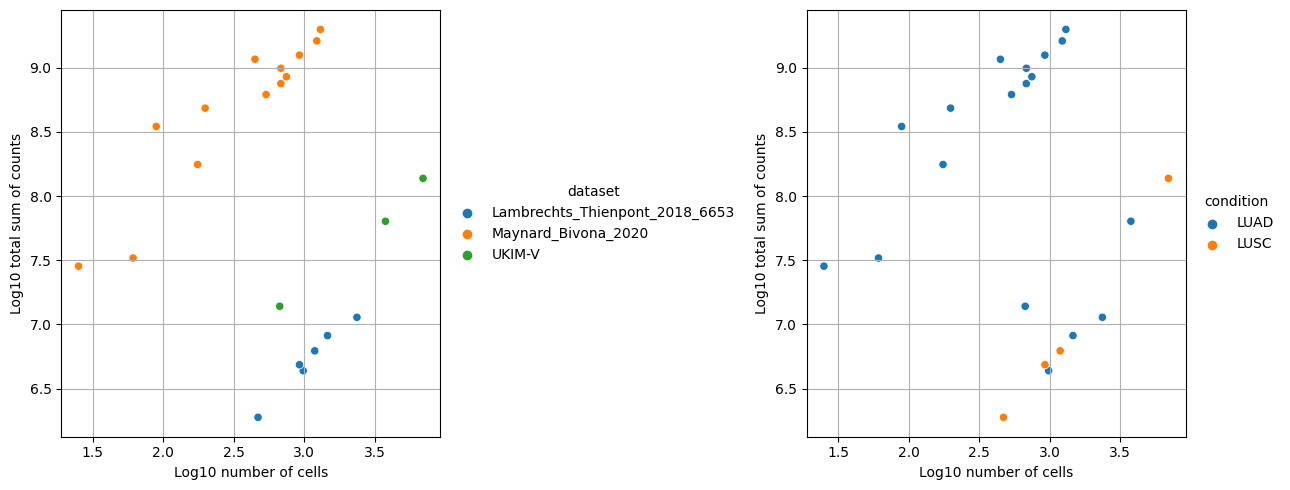

In [139]:
dc.plot_psbulk_samples(pdata, groupby=["dataset","condition"], figsize=(13,5))

Convention to filter low quality samples:

    - Number of cells --> min_cells (genes  minimum total number of reads across sample)
    - Number of counts --> min_counts (genes minimum number of counts in a number of samples)
    
Check the frequency of genes (features) vs n. of samples and total sum of counts with  ```plot_filter_by_expr```


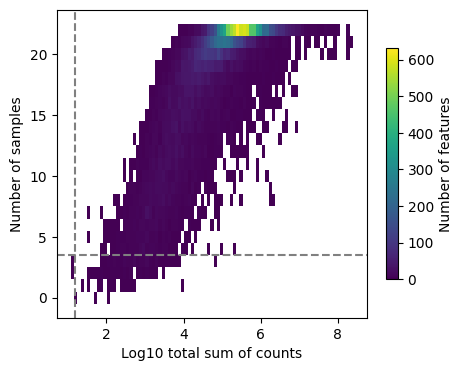

In [6]:
dc.plot_filter_by_expr(pdata, group='condition', min_count=10,min_total_count=15)

#  Define cell type to use

Specifiy for which cell type annotation level we want to run the differential expression analyses

In [362]:
cell_type = list(adata.obs["cell_type_coarse"].unique())

# Create dictionary of adatas subsetted by cell type

In [8]:
adata_dict = {}
for name in cell_type:
    name_ad = name.replace(" ","_")
    adata_name = f"{name_ad}_adata"
    adata_dict[adata_name] = adata[adata.obs["cell_type_coarse"].isin([name])]

#  Function: Run DESeq2 on pseudobulk of all cell types from cell_type 

In [141]:
def run_deseq(count_table, sample_sheet, deseq_prefix, contrast, deseq_resdir):
    os.makedirs(deseq_resdir, exist_ok = True)
    
    deseq_cmd = [deseq, count_table, sample_sheet,
                 "--cond_col", "condition",
                 "--c1", contrast[0],
                 "--c2", contrast[1], 
                 "--resDir", deseq_resdir, 
                 "--prefix", deseq_prefix, 
                 "--cpus", str(cpus), 
                 "--save_workspace"]
    with open(deseq_resdir + "/" + deseq_prefix + ".log", 'w') as stdout:
        with open(deseq_resdir + "/" + deseq_prefix + ".err", 'w') as stderr:
            sp.run(deseq_cmd, capture_output=False, stdout=stdout, stderr=stderr, check = True)

# Funciton: Save results from pseudobulk (samplesheet and counts) for all cell types from cell_type 

In [10]:
def save_pseudobulk(pb, samplesheet_filename, counts_filename):
    samplesheet = pb.obs.copy()
    samplesheet.reset_index(inplace=True)
    sample_ids_repl = fix_sample_ids(pb)
    bulk_df = pb.to_df().T.rename(columns=sample_ids_repl)
    bulk_df = pb.to_df().T
    bulk_df.index.name = "gene_id"
    samplesheet.to_csv(samplesheet_filename, index = False)
    bulk_df.to_csv(counts_filename)

# Function: Homogenize all sample ids

In [11]:
def fix_sample_ids(pb):
    repl = {}
    for k,v in dict(zip(pb.obs["condition"].index, "_"+pb.obs["condition"].values)).items():
        repl[k] = k.replace(v,"")

    return(repl)

# Create pseudobulk for each celltype using the coarse cell type annotation

In [12]:
for ct ,tmp_ad in adata_dict.items():    
    pb = dc.get_pseudobulk(
        tmp_ad,
        sample_col='sample',
        groups_col='condition',
        layer='raw_counts',
        mode='sum',
        min_prop=0.05,
        min_cells=10,
        min_counts=1000,
        min_smpls=2
    )
    if pb.obs["condition"].nunique() <= 1:
        print(f"Cell type {ct} does not have enough replicates per group")
    else:
        contrast = ["LUSC", "LUAD"]
        contrast_str = f"{contrast[0]}_vs_{contrast[1]}"
        deseq_resdir = f"{deseq_results}/{contrast_str}"

        ct = ct.replace(" ", "_")
        ct_fname = ct.replace("/", "_")
        deseq_prefix = f"{contrast_str}_{ct_fname}"
        
        sample_sheet = f"{deseq_results}/{deseq_prefix}.samplesheet.csv"
        count_table = f"{deseq_results}/{deseq_prefix}.counts.csv"

        save_pseudobulk(pb, sample_sheet, count_table)
        run_deseq(count_table, sample_sheet, deseq_prefix, contrast, deseq_resdir)
    

Cell type pDC_adata does not have enough replicates per group


In [344]:
contrasts = [
    {"name": "LUSC_vs_LUAD", "condition": "LUSC", "reference": "LUAD"},
]
contrasts

# Cell type name without space for file name
cell_type_fn = [j.replace(" ","_").replace("/","_") for i,j in enumerate(cell_type)]

In [349]:
# Get results from folder 
for contrast in contrasts:
    de_res = {}
    
    for ct in cell_type_fn:

        csv_file = glob.glob(deseq_resdir + "/" + contrast["name"] + "_" + ct + "_adata_DESeq2_result.tsv")
        if len(csv_file)>0:

            res_df = pd.read_csv(csv_file[0], sep = "\t")
            res_df = res_df.set_index(["gene_id"])
            ct = ct.replace("_"," ")
            # Register cell type results
            de_res[ct] = res_df
    contrast["de_res"] = de_res

In [350]:
# Concat and build the log2FoldChange change matrix
for contrast in contrasts:
    lfc_mat = (
        pd.concat(
            [
                res.loc[:, ["log2FoldChange"]].rename(columns={"log2FoldChange": ct})
                for ct, res in contrast["de_res"].items()
            ],
            axis=1,
            sort=True,
        )
        .fillna(0)
        .T
    )
    contrast["lfc_mat"] = lfc_mat
    display(lfc_mat)

gene_id,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.844176,0.006757,0.000000,0.000000,0.607343,-0.990843,-0.514743,0.000000,0.00000,0.000000,...,-1.029318,-0.047193,0.000000,0.000000,-0.678305,-0.750736,0.00000,-0.613955,0.213759,0.285737
T cell,1.203477,-0.716934,-2.690400,0.433373,0.000000,-1.027059,-0.978157,0.000000,0.00000,0.000000,...,0.298179,-0.572825,-1.599395,-0.553147,-0.362671,-0.516628,0.00000,-0.550537,-0.232492,-0.552652
Epithelial cell,2.815056,1.210502,-1.401098,0.000000,3.675422,-1.117362,-0.037587,-1.915396,0.39859,-1.281003,...,0.521813,0.808396,0.725054,-1.137472,-0.597799,-1.124733,0.90543,-0.251799,-0.668161,-0.343046
Macrophage Monocyte,1.487030,-1.123829,0.145350,0.000000,0.000000,-0.319985,-1.767535,0.000000,0.00000,0.000000,...,1.563404,0.561681,1.645297,1.569380,-0.135443,-1.386529,0.00000,0.576349,-0.522319,-0.615074
Mast cell,1.330324,0.683041,-2.805651,1.190396,0.000000,-0.072847,-1.799984,0.000000,0.00000,0.000000,...,0.023532,-0.162155,0.000000,0.000000,-1.274370,-0.872984,0.00000,0.587884,-0.510661,-3.967850
Plasma cell,1.545453,-0.994224,-1.910412,0.000000,0.000000,-0.674704,-1.929589,0.000000,0.00000,0.000000,...,1.227370,-0.238320,0.000000,0.000000,-0.408152,-0.141112,0.00000,0.221094,-1.066368,0.159145
cDC,1.673694,-1.320751,0.443465,0.000000,4.743388,0.933563,-0.058517,0.000000,0.00000,0.000000,...,0.754288,0.089263,1.588524,0.000000,-1.996076,-0.196220,0.00000,-0.678342,-0.740271,-0.964634
Stromal,0.839880,-2.688464,-2.728765,-2.234240,2.516648,-0.853038,-0.787340,0.000000,0.00000,0.000000,...,1.600856,-0.387238,-2.440952,0.000000,1.165751,-0.123808,0.00000,0.823734,-1.182425,-2.077494
NK cell,1.584763,1.968235,-0.737383,1.057091,2.033426,0.922729,-2.495141,0.000000,0.00000,0.000000,...,0.000000,1.876178,1.241347,0.000000,-0.693514,-0.123082,0.00000,-0.343649,-0.791023,-0.497292
Endothelial cell,-0.214152,-1.506879,-0.668398,-1.322133,0.538021,-0.757185,3.877790,0.000000,0.00000,0.000000,...,-2.760115,3.190955,0.000000,-0.486120,1.725801,-1.691588,0.00000,1.340342,1.202586,-4.091927


In [351]:
# Concat and build the fdr
for contrast in contrasts:
    fdr_mat = (
        pd.concat(
            [res.loc[:, ["padj"]].rename(columns={"padj": ct}) for ct, res in contrast["de_res"].items()],
            axis=1,
            sort=True,
        )
        .fillna(1)
        .T
    )
    contrast["fdr_mat"] = fdr_mat
    display(fdr_mat)

gene_id,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
T cell,0.778974,1.0,0.950742,1.0,1.000000,0.957344,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,0.665240,1.000000
Epithelial cell,0.230604,1.0,1.000000,1.0,1.000000,0.337882,1.000000,1.0,1.0,1.0,...,1.0,1.0,0.858181,1.0,1.0,1.000000,1.0,1.0,0.508580,1.000000
Macrophage Monocyte,0.830778,1.0,1.000000,1.0,1.000000,1.000000,0.909704,1.0,1.0,1.0,...,1.0,1.0,0.872215,1.0,1.0,1.000000,1.0,1.0,0.579376,1.000000
Mast cell,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,0.691670
Plasma cell,0.213593,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
cDC,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,0.608535,1.000000
Stromal,1.000000,1.0,0.227388,1.0,0.561715,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
NK cell,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,0.668981,1.000000
Endothelial cell,1.000000,1.0,0.723326,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,0.566246,1.000000


In [352]:
# Concat and build the stat matrix
for contrast in contrasts:
    stat_mat = (
        pd.concat(
            [res.loc[:, ["stat"]].rename(columns={"stat": ct}) for ct, res in contrast["de_res"].items()],
            axis=1,
            sort=True,
        )
        .fillna(0)
        .T
    )
    contrast["stat_mat"] = stat_mat
    display(stat_mat)

gene_id,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.788465,0.005648,0.000000,0.000000,0.373400,-0.741296,-0.360066,0.000000,0.000000,0.00000,...,-0.601976,-0.037578,0.000000,0.000000,-0.465748,-0.599699,0.000000,-0.435061,0.297194,0.265000
T cell,1.615292,-0.828232,-2.467348,0.399614,0.000000,-1.388286,-1.072027,0.000000,0.000000,0.00000,...,0.269178,-0.620639,-1.048165,-0.431442,-0.350130,-0.483646,0.000000,-0.602491,-0.619865,-1.002858
Epithelial cell,2.226235,1.102526,-0.929260,0.000000,3.413377,-1.669436,-0.064659,-1.693045,0.120547,-1.06136,...,0.562382,1.158395,0.776785,-0.852727,-0.882949,-1.333169,0.787453,-0.460369,-0.968913,-0.614505
Macrophage Monocyte,1.558852,-0.923059,0.178707,0.000000,0.000000,-0.436929,-1.570917,0.000000,0.000000,0.00000,...,1.536933,0.660424,1.477473,0.916104,-0.072340,-1.578558,0.000000,1.043998,-1.283017,-1.137666
Mast cell,1.435166,0.395946,-1.889292,1.120800,0.000000,-0.079911,-1.337397,0.000000,0.000000,0.00000,...,0.018223,-0.121945,0.000000,0.000000,-0.698597,-0.573074,0.000000,0.686822,-0.662403,-2.859850
Plasma cell,2.282523,-0.622258,-1.114665,0.000000,0.000000,-0.841571,-1.730307,0.000000,0.000000,0.00000,...,0.873124,-0.132795,0.000000,0.000000,-0.230560,-0.095347,0.000000,0.178624,-0.898970,0.182694
cDC,1.834709,-0.873799,0.422538,0.000000,2.165011,1.013160,-0.041538,0.000000,0.000000,0.00000,...,0.497002,0.080203,0.949575,0.000000,-1.332212,-0.134944,0.000000,-0.580629,-1.311559,-0.957552
Stromal,0.527468,-1.451667,-3.077742,-0.903472,2.601325,-0.655082,-0.455064,0.000000,0.000000,0.00000,...,0.743349,-0.243503,-0.995089,0.000000,0.525255,-0.109787,0.000000,0.659849,-1.601108,-1.426180
NK cell,1.056890,0.873450,-0.334030,0.464271,0.678536,0.617746,-1.636150,0.000000,0.000000,0.00000,...,0.000000,0.913833,0.647592,0.000000,-0.265400,-0.067551,0.000000,-0.187932,-1.149648,-0.538337
Endothelial cell,-0.078867,-0.313443,-0.820749,-0.361649,0.454968,-0.350312,1.683491,0.000000,0.000000,0.00000,...,-0.942084,1.194149,0.000000,-0.100732,0.779966,-0.458815,0.000000,1.246739,1.225418,-1.616970


In [353]:
logFCs = contrast["lfc_mat"]
logFCs

gene_id,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.844176,0.006757,0.000000,0.000000,0.607343,-0.990843,-0.514743,0.000000,0.00000,0.000000,...,-1.029318,-0.047193,0.000000,0.000000,-0.678305,-0.750736,0.00000,-0.613955,0.213759,0.285737
T cell,1.203477,-0.716934,-2.690400,0.433373,0.000000,-1.027059,-0.978157,0.000000,0.00000,0.000000,...,0.298179,-0.572825,-1.599395,-0.553147,-0.362671,-0.516628,0.00000,-0.550537,-0.232492,-0.552652
Epithelial cell,2.815056,1.210502,-1.401098,0.000000,3.675422,-1.117362,-0.037587,-1.915396,0.39859,-1.281003,...,0.521813,0.808396,0.725054,-1.137472,-0.597799,-1.124733,0.90543,-0.251799,-0.668161,-0.343046
Macrophage Monocyte,1.487030,-1.123829,0.145350,0.000000,0.000000,-0.319985,-1.767535,0.000000,0.00000,0.000000,...,1.563404,0.561681,1.645297,1.569380,-0.135443,-1.386529,0.00000,0.576349,-0.522319,-0.615074
Mast cell,1.330324,0.683041,-2.805651,1.190396,0.000000,-0.072847,-1.799984,0.000000,0.00000,0.000000,...,0.023532,-0.162155,0.000000,0.000000,-1.274370,-0.872984,0.00000,0.587884,-0.510661,-3.967850
Plasma cell,1.545453,-0.994224,-1.910412,0.000000,0.000000,-0.674704,-1.929589,0.000000,0.00000,0.000000,...,1.227370,-0.238320,0.000000,0.000000,-0.408152,-0.141112,0.00000,0.221094,-1.066368,0.159145
cDC,1.673694,-1.320751,0.443465,0.000000,4.743388,0.933563,-0.058517,0.000000,0.00000,0.000000,...,0.754288,0.089263,1.588524,0.000000,-1.996076,-0.196220,0.00000,-0.678342,-0.740271,-0.964634
Stromal,0.839880,-2.688464,-2.728765,-2.234240,2.516648,-0.853038,-0.787340,0.000000,0.00000,0.000000,...,1.600856,-0.387238,-2.440952,0.000000,1.165751,-0.123808,0.00000,0.823734,-1.182425,-2.077494
NK cell,1.584763,1.968235,-0.737383,1.057091,2.033426,0.922729,-2.495141,0.000000,0.00000,0.000000,...,0.000000,1.876178,1.241347,0.000000,-0.693514,-0.123082,0.00000,-0.343649,-0.791023,-0.497292
Endothelial cell,-0.214152,-1.506879,-0.668398,-1.322133,0.538021,-0.757185,3.877790,0.000000,0.00000,0.000000,...,-2.760115,3.190955,0.000000,-0.486120,1.725801,-1.691588,0.00000,1.340342,1.202586,-4.091927


In [ ]:
"""
for contrast in contrasts:
    # Extract logFCs and pvals
    logFCs = contrast["lfc_mat"]
    pvals = contrast["fdr_mat"]

    # Initialize the figure panel
    ncols = int(len(cell_type)/4)
    nrows = int(len(cell_type)/4)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
    empty_axs = axs.flatten()
    axs = [{"ct": ax} for ct, ax in zip(cell_type, axs.flatten())]

    for ax in axs:
        dc.plot_volcano(
            logFCs,
            pvals,
            ax["ct"],
            name=ax["ct"],
            top=10,
            sign_thr=0.1,
            lFCs_thr=0.5,
            return_fig=False,
            ax=ax["ct"],
        )

    # set empty axes invisible
    for ax in range(len(axs), len(empty_axs)):
        empty_axs[ax].set_visible(False)

    plt.tight_layout()
    plt.show()
"""

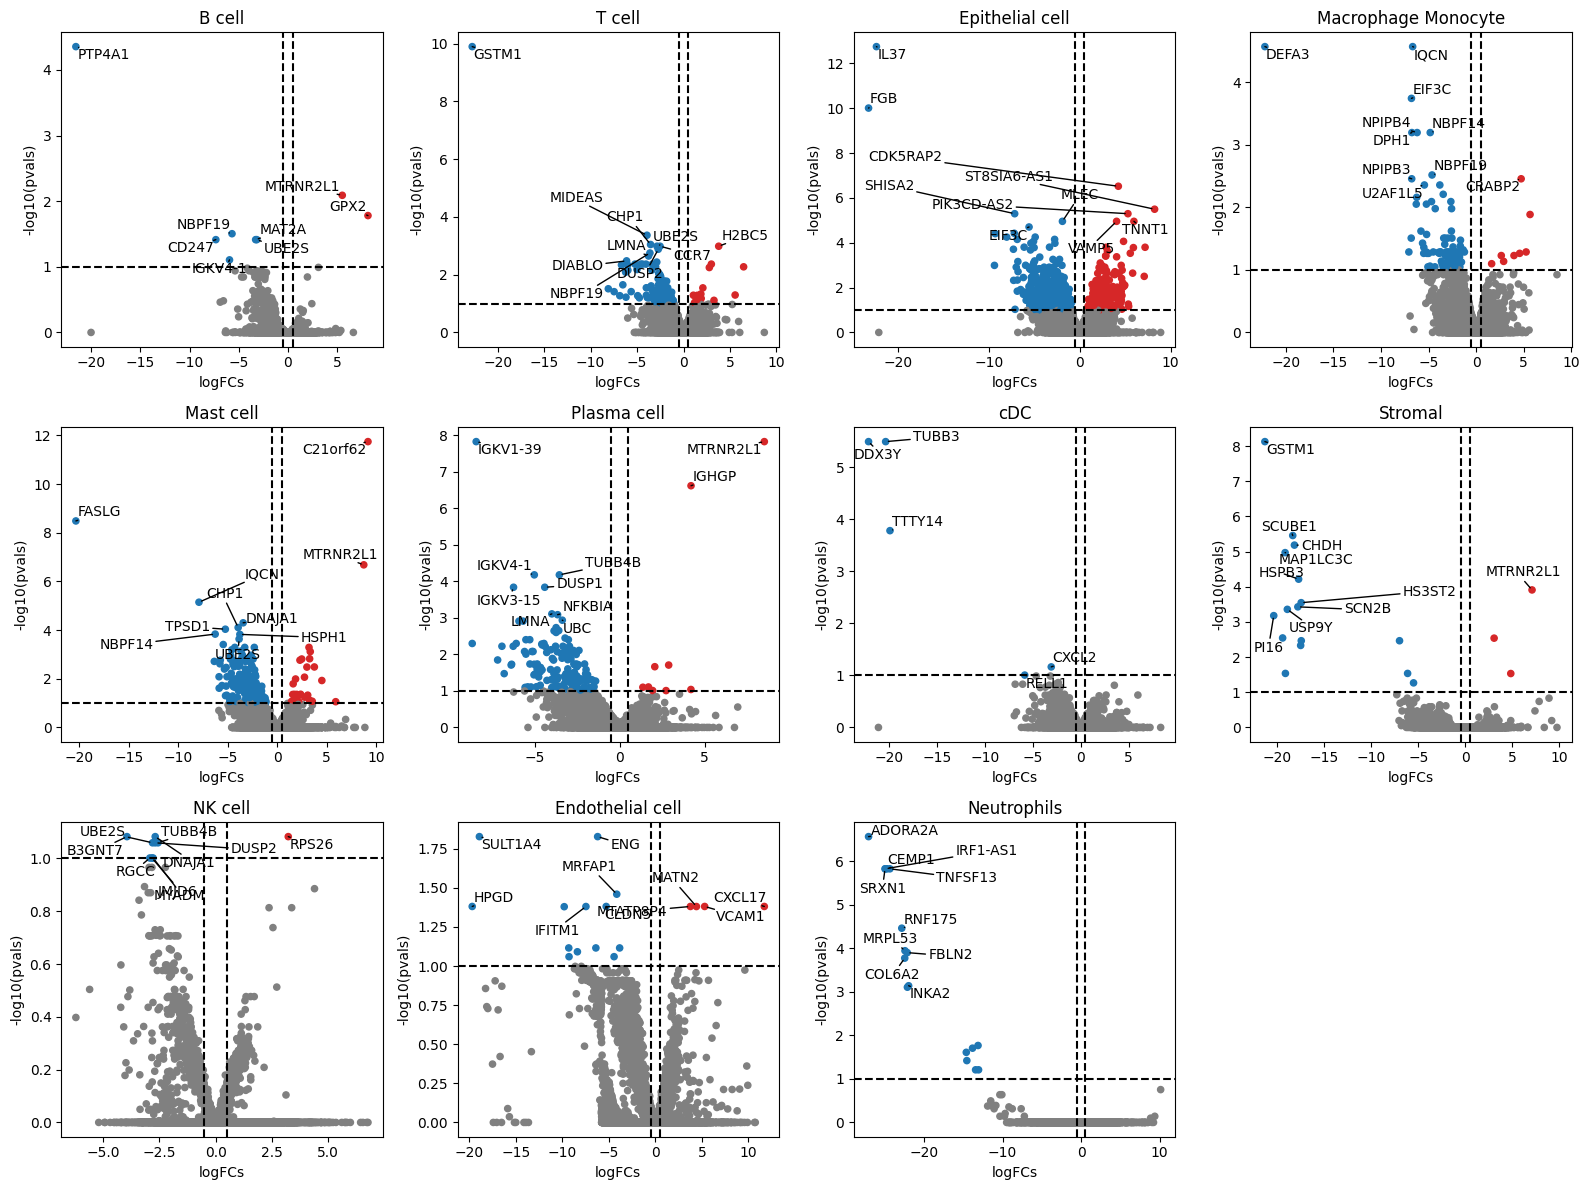

In [370]:
# Define transcription factors of interest
tf_of_interest = ["PTP4A1"]

for contrast in contrasts:
    # Extract logFCs and pvals
    logFCs = contrast["lfc_mat"]
    pvals = contrast["fdr_mat"]
    #tf_pvals = contrast["tf_pvals"]

    # get sig ct for tfoi
    n_sig = 0
    sig_tf = {}
    cell_type = list(logFCs.index)
    for ct in cell_type:
        for tfoi in tf_of_interest:
                if tfoi not in sig_tf:
                    sig_tf[tfoi] = []
                sig_tf[tfoi].append({"ct": ct, "tf": tfoi})
                n_sig += 1

    # generate a volcano plot panel for each transcription factor of interest:
    # the panels show volcano plots for each celltype in which there is a
    # signigicant transcription factor activity
    for tf in sig_tf.keys():
        n_sig = len(sig_tf[tf])

        # Calculate nrows based on ncol
        ncols = 4 if n_sig >= 4 else n_sig
        nrows = int(np.ceil(n_sig / ncols))

        # Initialize the figure panel
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
        empty_axs = axs.flatten()
        axs = [{"ct_tf": ct_tf, "ax": ax} for ct_tf, ax in zip(sig_tf[tf], axs.flatten())]
     
        for ax in axs:
            dc.plot_volcano(
                logFCs,
                pvals,
                ax["ct_tf"]["ct"],
                name=ax["ct_tf"]["tf"],
                top=10,
                sign_thr=0.1,
                lFCs_thr=0.5,
                return_fig=False,
                ax=ax["ax"],
            )

        # set empty axes invisible
        for ax in range(len(axs), len(empty_axs)):
            empty_axs[ax].set_visible(False)

        plt.tight_layout()
        plt.show()


In [13]:
def plot_paired(
    adata,
    groupby,
    *,
    paired_by=None,
    var_names=None,
    show=True,
    return_fig=False,
    n_cols=4,
    panel_size=(3, 4),
    show_legend=True,
    hue=None,
    size=10,
    ylabel="expression",
    pvalues: Sequence[float] = None,
    pvalue_template=lambda x: f"unadj. p={x:.2f}, t-test",
    adjust_fdr=False,
    boxplot_properties=None,
):
    """
    Pairwise expression plot.
    Makes on panel with a paired scatterplot for each variable.
    Parameters
    ----------
    adata
        adata matrix (usually pseudobulk).
    group_by
        Column containing the grouping. Must contain exactely two different values.
    paired_by
        Column indicating the pairing (e.g. "patient")
    var_names
        Only plot these variables. Default is to plot all
    """
    if boxplot_properties is None:
        boxplot_properties = {}
    groups = adata.obs[groupby].unique()
    if len(groups) != 2:
        raise ValueError(
            "The number of groups in the group_by column must be exactely 2"
        )

    if var_names is None:
        var_names = adata.var_names
        if len(var_names) > 20:
            warnings.warn(
                "You are plotting more than 20 variables which may be slow. "
                "Explicitly set the `var_names` paraloeter to turn this off. "
            )

    X = adata[:, var_names].X
    try:
        X = X.toarray()
    except AttributeError:
        pass

    groupby_cols = [groupby]
    if paired_by is not None:
        groupby_cols.insert(0, paired_by)
    if hue is not None:
        groupby_cols.insert(0, hue)

    df = adata.obs.loc[:, groupby_cols].join(
        pd.DataFrame(X, index=adata.obs_names, columns=var_names)
    )

    if paired_by is not None:
        # remove unpaired samples
        df[paired_by] = df[paired_by].astype(str)
        df.set_index(paired_by, inplace=True)
        has_matching_samples = df.groupby(paired_by).apply(
            lambda x: sorted(x[groupby]) == sorted(groups)
        )
        has_matching_samples = has_matching_samples.index[has_matching_samples].values
        removed_samples = adata.obs[paired_by].nunique() - len(has_matching_samples)
        if removed_samples:
            warnings.warn(f"{removed_samples} unpaired samples removed")

        # perform statistics (paired ttest)
        if pvalues is None:
            _, pvalues = scipy.stats.ttest_rel(
                df.loc[
                    df[groupby] == groups[0],
                    var_names,
                ].loc[has_matching_samples, :],
                df.loc[
                    df[groupby] == groups[1],
                    var_names,
                ].loc[has_matching_samples],
            )

        df = df.loc[has_matching_samples, :]
        df.reset_index(drop=False, inplace=True)

    else:
        if pvalues is None:
            _, pvalues = scipy.stats.ttest_ind(
                df.loc[
                    df[groupby] == groups[0],
                    var_names,
                ],
                df.loc[
                    df[groupby] == groups[1],
                    var_names,
                ],
            )

    if adjust_fdr:
        pvalues = statsmodels.stats.multitest.fdrcorrection(pvalues)[1]

    # transform data for seaborn
    df_melt = df.melt(
        id_vars=groupby_cols,
        var_name="var",
        value_name="val",
    )

    # start plotting
    n_panels = len(var_names)
    nrows = ceil(n_panels / n_cols)
    ncols = min(n_cols, n_panels)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(ncols * panel_size[0], nrows * panel_size[1]),
        tight_layout=True,
        squeeze=False,
    )
    axes = axes.flatten()
    if hue is None:
        hue = paired_by
    for i, (var, ax) in enumerate(zip_longest(var_names, axes)):
        if var is not None:
            sns.stripplot(
                x=groupby,
                data=df_melt.loc[lambda x: x["var"] == var],
                y="val",
                ax=ax,
                hue=hue,
                size=size,
                linewidth=1,
            )
            if paired_by is not None:
                sns.lineplot(
                    x=groupby,
                    data=df_melt.loc[lambda x: x["var"] == var],
                    hue=hue,
                    y="val",
                    ax=ax,
                    legend=False,
                    ci=None,
                )
            sns.boxplot(
                x=groupby,
                data=df_melt.loc[lambda x: x["var"] == var],
                y="val",
                ax=ax,
                color="white",
                fliersize=0,
                **boxplot_properties,
            )

            ax.set_xlabel("")
            ax.tick_params(
                axis="x",
                # rotation=0,
                labelsize=15,
            )
            ax.legend().set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_title(var + "\n" + pvalue_template(pvalues[i]))
        else:
            ax.set_visible(False)
    fig.tight_layout()

    if show_legend == True:
        axes[n_panels - 1].legend().set_visible(True)
        axes[n_panels - 1].legend(bbox_to_anchor=(1.1, 1.05))

    if show:
        plt.show()

    if return_fig:
        return fig